## Prompt Engineering at Scale - Mentored Learning Session

**Objectives from this session:**

- Answer any questions from the week's Live Teaching Session
- Recap the "Patient Review Analysis" caselet from the previous PE without code session
- The goal of this session is to learn how to practically code the solution on Python using the Azure OpenAI API
- In the real world, data will be available to you in the form of CSV files, and this session is intended to teach you how to apply a prompt to that dataset and generate data from an LLM

### Getting setup

In [17]:
# Get updates on what's going on in the background
%pip install openai==0.28 tiktoken session-info --quiet

160.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Import all Python packages required to access the Azure OpenAI API
import openai # to wrok wth gpt-3.5-turbo model - this is our LLM
import json # to extract results from the LLM response
import tiktoken # to see background progress
import session_info # to get details on the colab session
import pandas as pd # to work with datasets
import time # to pause iterations - to account for rate limits
import os # access to environment variables for security

In [19]:
session_info.show()

### Creating your Configuration File

Go to your chat playground, make sure the deployment model is **gpt-35-turbo**, and open up **View Code** - this is where you can find all the necessary information to get setup with your config file

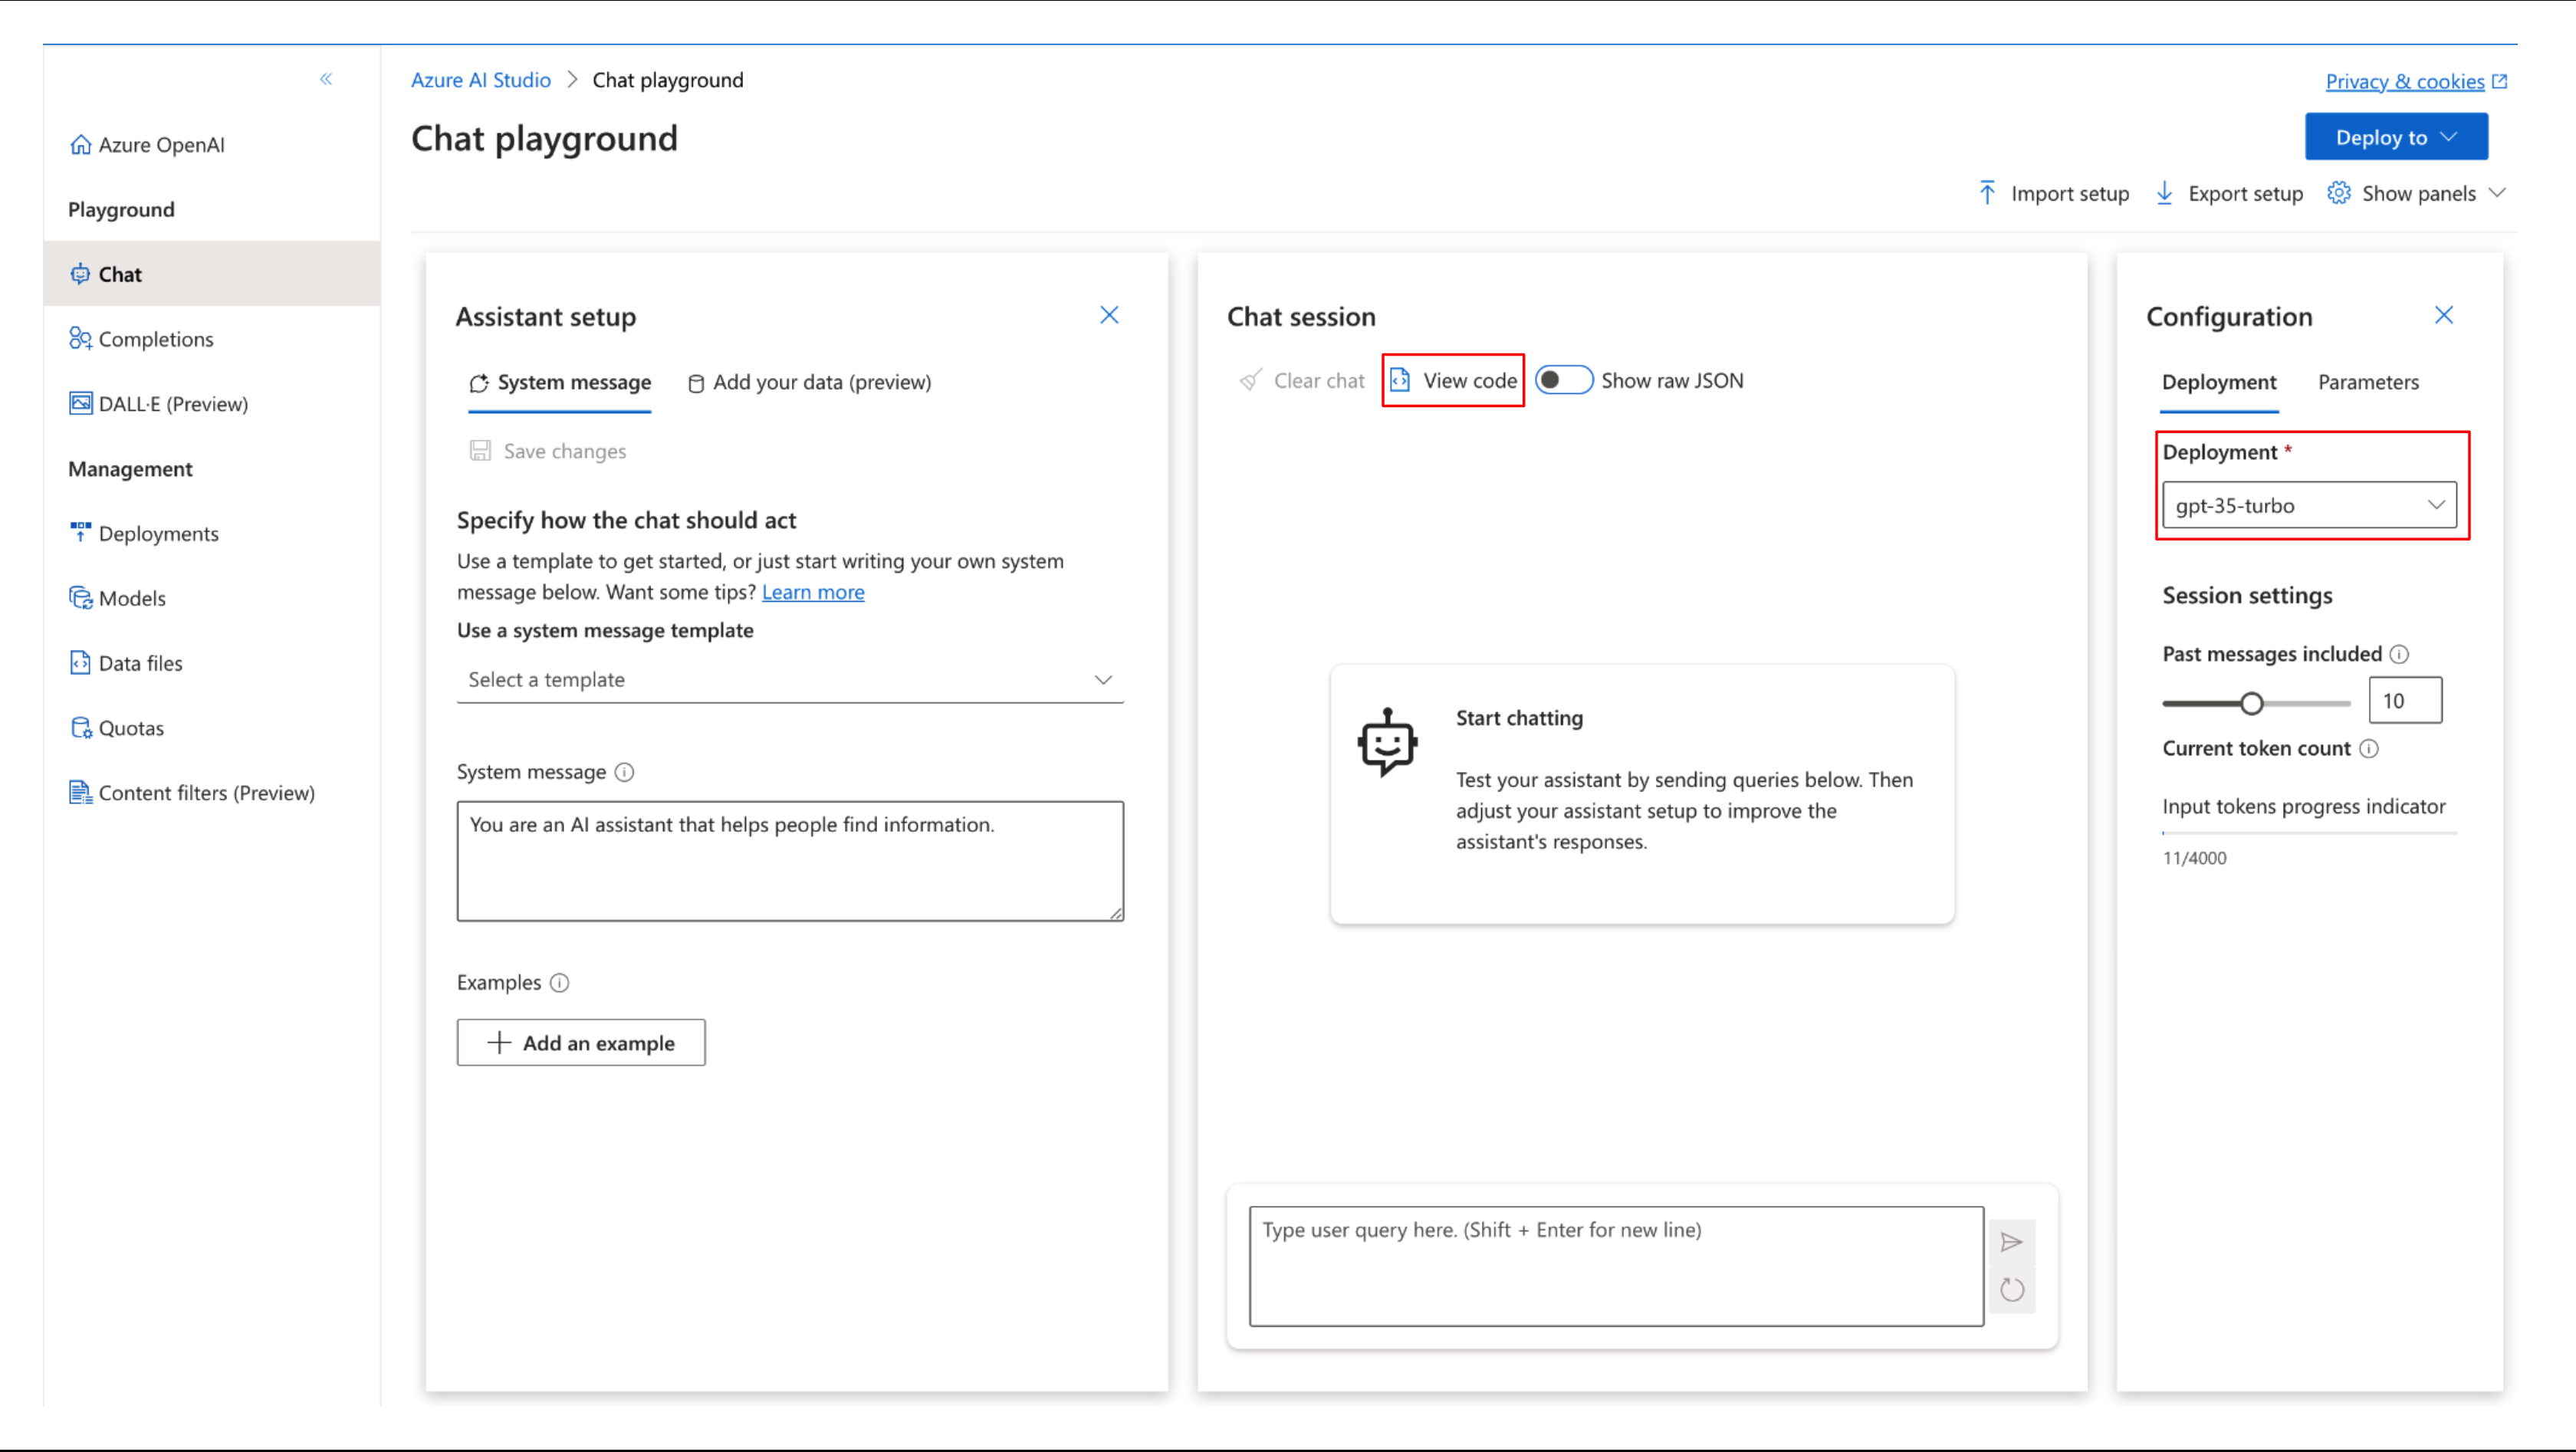

Follow the below illustration to create your **config.json** file

**Important**: The reason why we use a config file is because it is not a good security practice to expose your api key's and endpoint in a sharable notebook

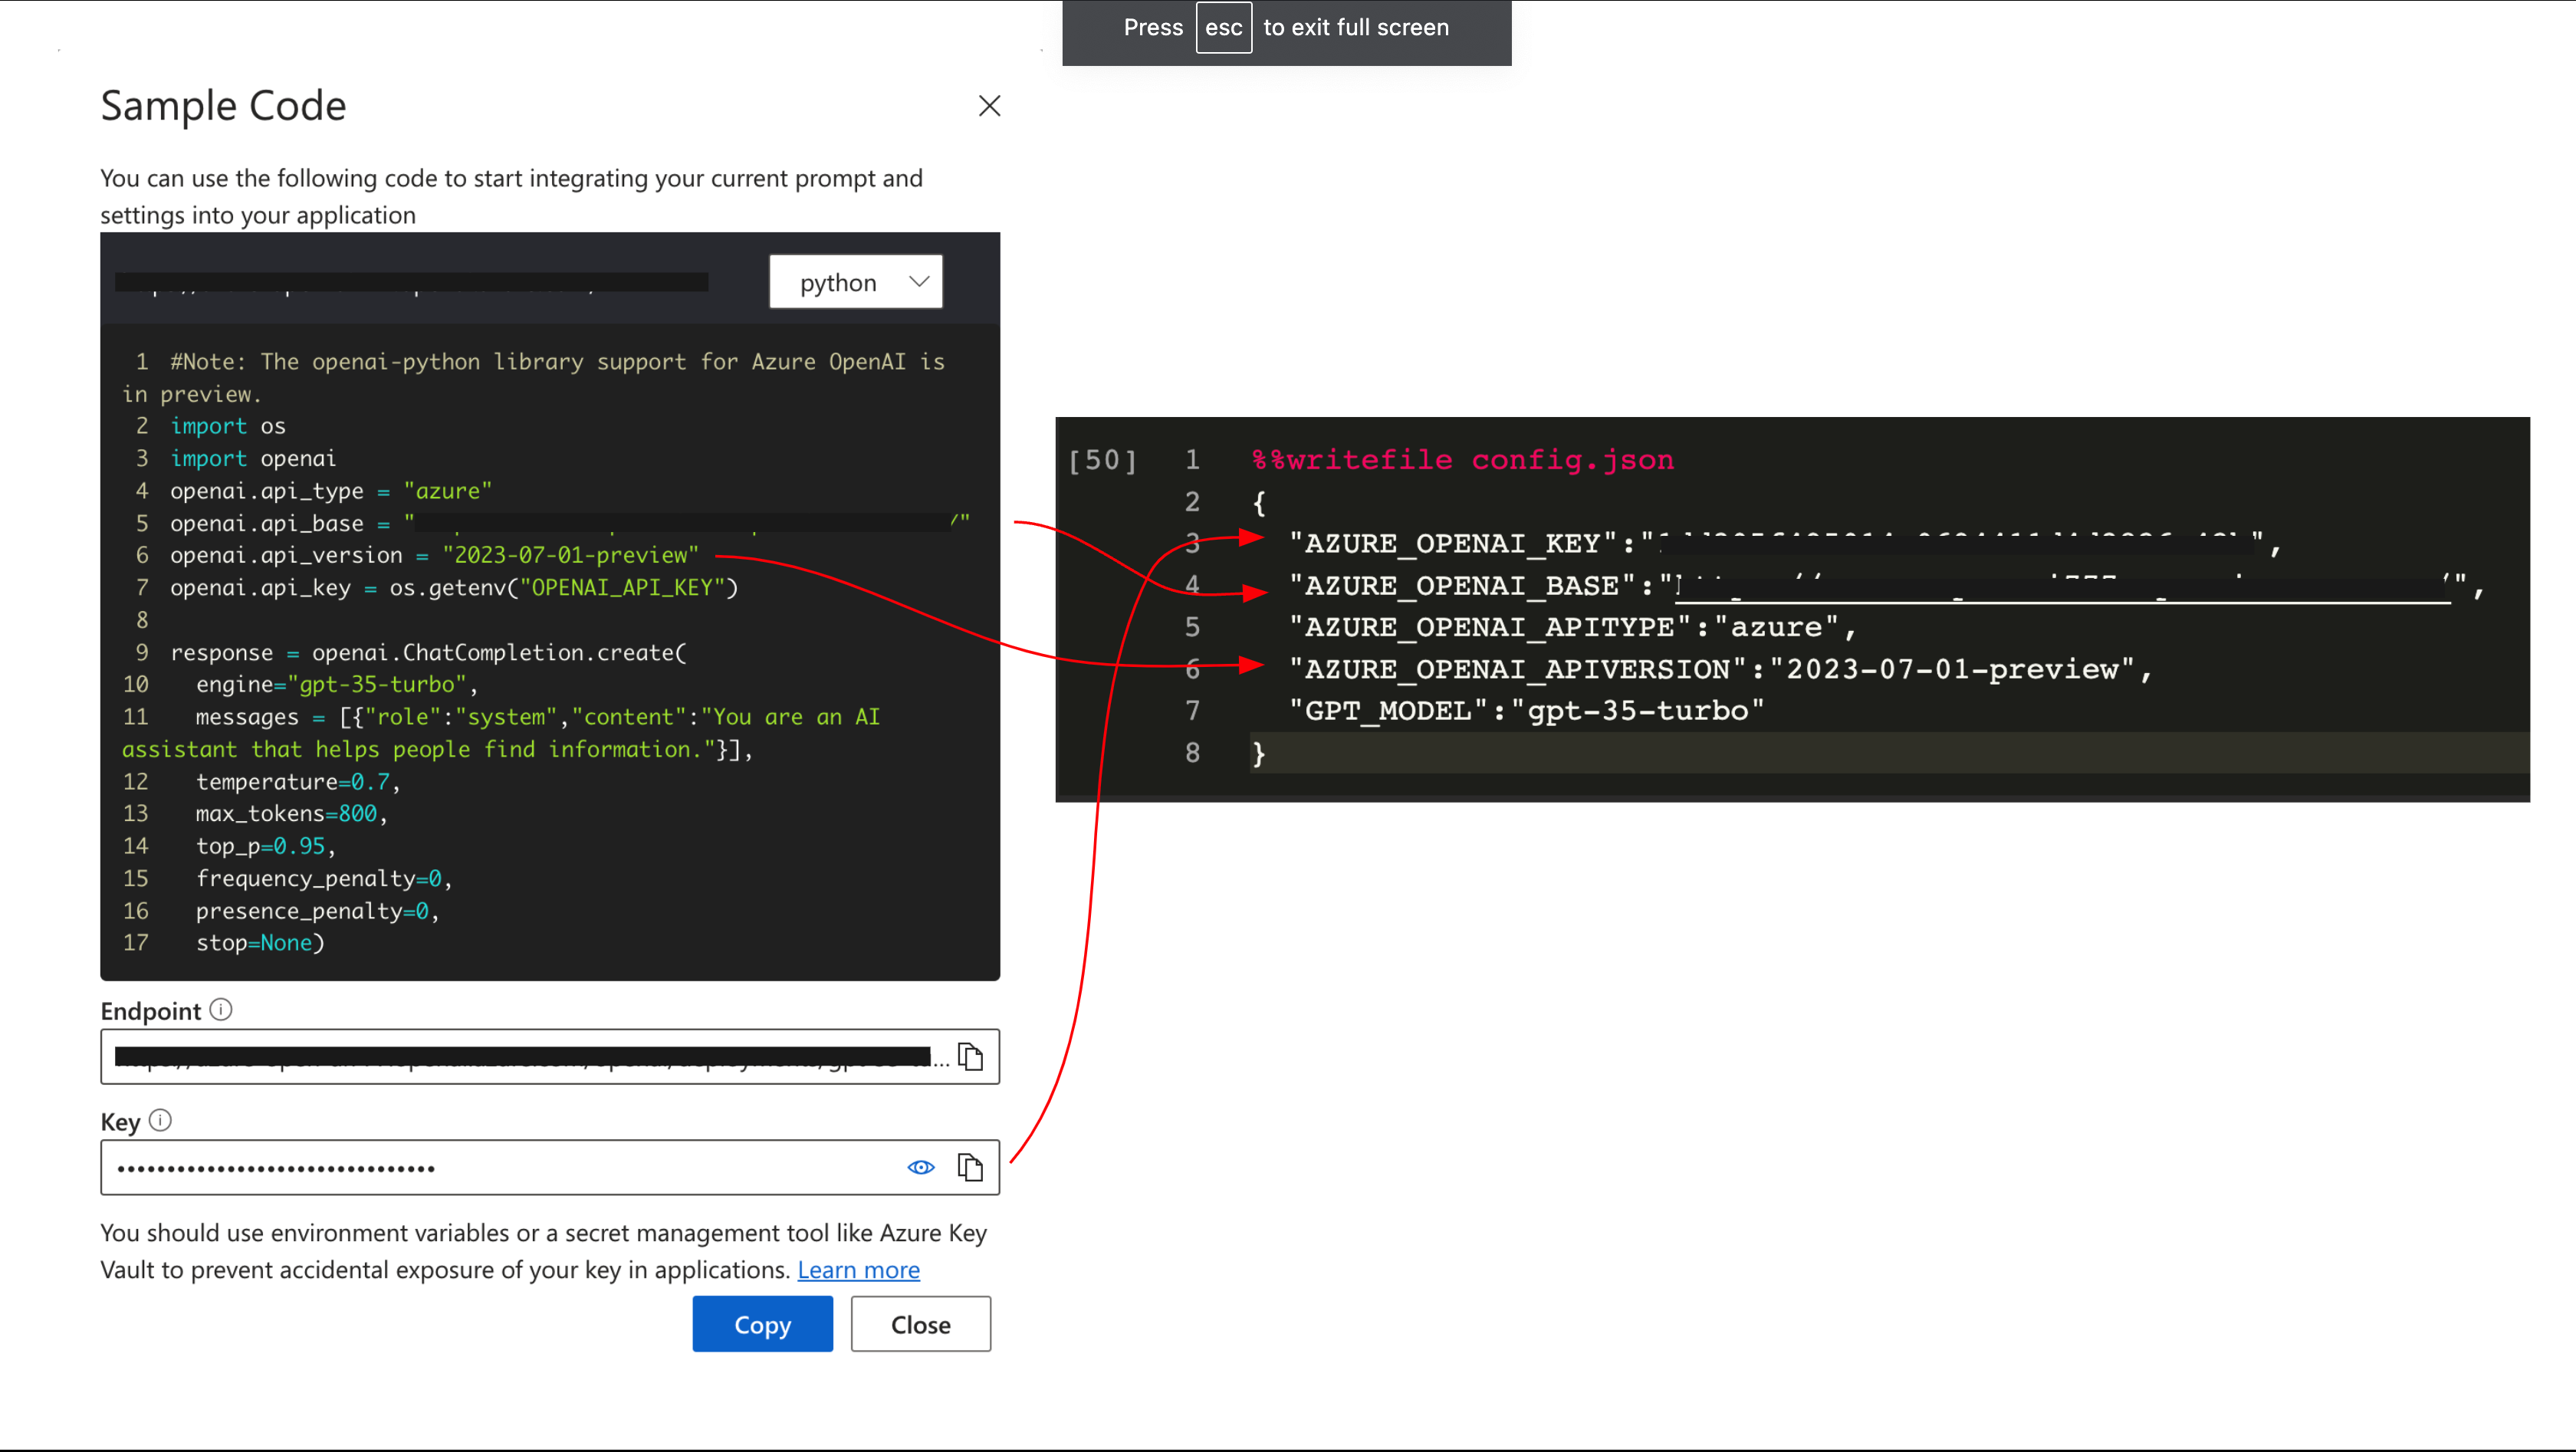

In [20]:
# %%writefile config.json
# {
#   "AZURE_OPENAI_KEY":"",
#   "AZURE_OPENAI_BASE":"",
#   "AZURE_OPENAI_APITYPE":"azure",
#   "AZURE_OPENAI_APIVERSION":"2023-07-01-preview",
#   "GPT_MODEL":"gpt-35-turbo"
# }

### Getting setup with Azure OpenAI

In [21]:
# Read the key value pairs from the json file

# with open('config.json', 'r') as az_creds:
#     data = az_creds.read()

In [22]:
# convert this into a dictionary so we can extract items from it using an index
# creds = json.loads(data)

In [23]:
# Credentials to authenticate to the personalized Open AI model server
# openai.api_key = creds["AZURE_OPENAI_KEY"]
# openai.api_base = creds["AZURE_OPENAI_BASE"]
# openai.api_type = creds["AZURE_OPENAI_APITYPE"]
# openai.api_version = creds["AZURE_OPENAI_APIVERSION"]

# # Deployment id of the ChatCompletion endpoint
# chat_model_id = creds["GPT_MODEL"]

In [24]:
os.environ

environ{'AWS_PROFILE': 'default',
        'CLICOLOR': '1',
        'COMMAND_MODE': 'unix2003',
        'DISPLAY': '/private/tmp/com.apple.launchd.g1ndUPHLO9/org.xquartz:0',
        'EDITOR': 'nano',
        'GOPATH': '/Users/robertbarrimond/Developer/Go',
        'HOME': '/Users/robertbarrimond',
        'JAVA_HOME': '/usr/local/Cellar/openjdk/21.0.2/libexec/openjdk.jdk/Contents/Home',
        'LIQUIBASE_HOME': '/usr/local/opt/liquibase/libexec',
        'LOGNAME': 'robertbarrimond',
        'LSCOLORS': 'exfxcxdxbxegedabagacad',
        'MallocNanoZone': '0',
        'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
        'PATH': '/Users/robertbarrimond/Developer/gen-ai-msft/.venv/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/go/bin:/usr/local/MacGPG2/bin:/usr/local/munki:/opt/X11/bin:/Library/Apple/usr/bin:/Applications/Wireshark.app/Contents/MacOS:/Users/robertbarrimond/.rvm/bin:/usr/local/sbin',
        'PROMPT': '%m %~ %# ',
        'PWD': '/',
      

In [25]:
# Credentials to authenticate to the personalized Open AI model server
openai.api_key = os.environ["AZURE_OPENAI_KEY"]
openai.api_base = os.environ["AZURE_OPENAI_BASE"]
openai.api_type = os.environ["AZURE_OPENAI_APITYPE"]
openai.api_version = os.environ["AZURE_OPENAI_APIVERSION"]

# Deployment id of the ChatCompletion endpoint
chat_model_id = os.environ["GPT_MODEL"]

### Test your Azure OpenAI Response

In [26]:
# Create a Completion Function
def get_completion(prompt):
  response = openai.ChatCompletion.create(
    engine=chat_model_id,
    messages = [{"role": "user", "content": prompt}],
    temperature=0.7, # controls randomness of output
    max_tokens=800, # controls # of words in the output + input
    top_p=0.95,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None)

  return response.choices[0].message["content"]

In [27]:
get_completion("Hi")

'Hello! How may I assist you today?'

### Patient Review Analysis - a recap


**Objective**: You are a Data Scientist / Data Analyst working with a Healthcare provider. Lately, the organization is hearing multiple complaints and stories of dissatisfaction with the consultation provided and wants to analyze all the data to perform a root cause analysis to see where the problem is. You are given a large amount of unstructured data containing patient reviews which were given after consulting with your contracted doctors. Your task is to write an effective prompt to extract the patient’s name, the consulting doctor and their credentials, the ratings, a summary of the review, if or not the patient was satisfied with the consultation and tags related to a dissatisfied consultation. The samples are available to you in a csv file called **patient_review.csv**

This is how we did it **without code**

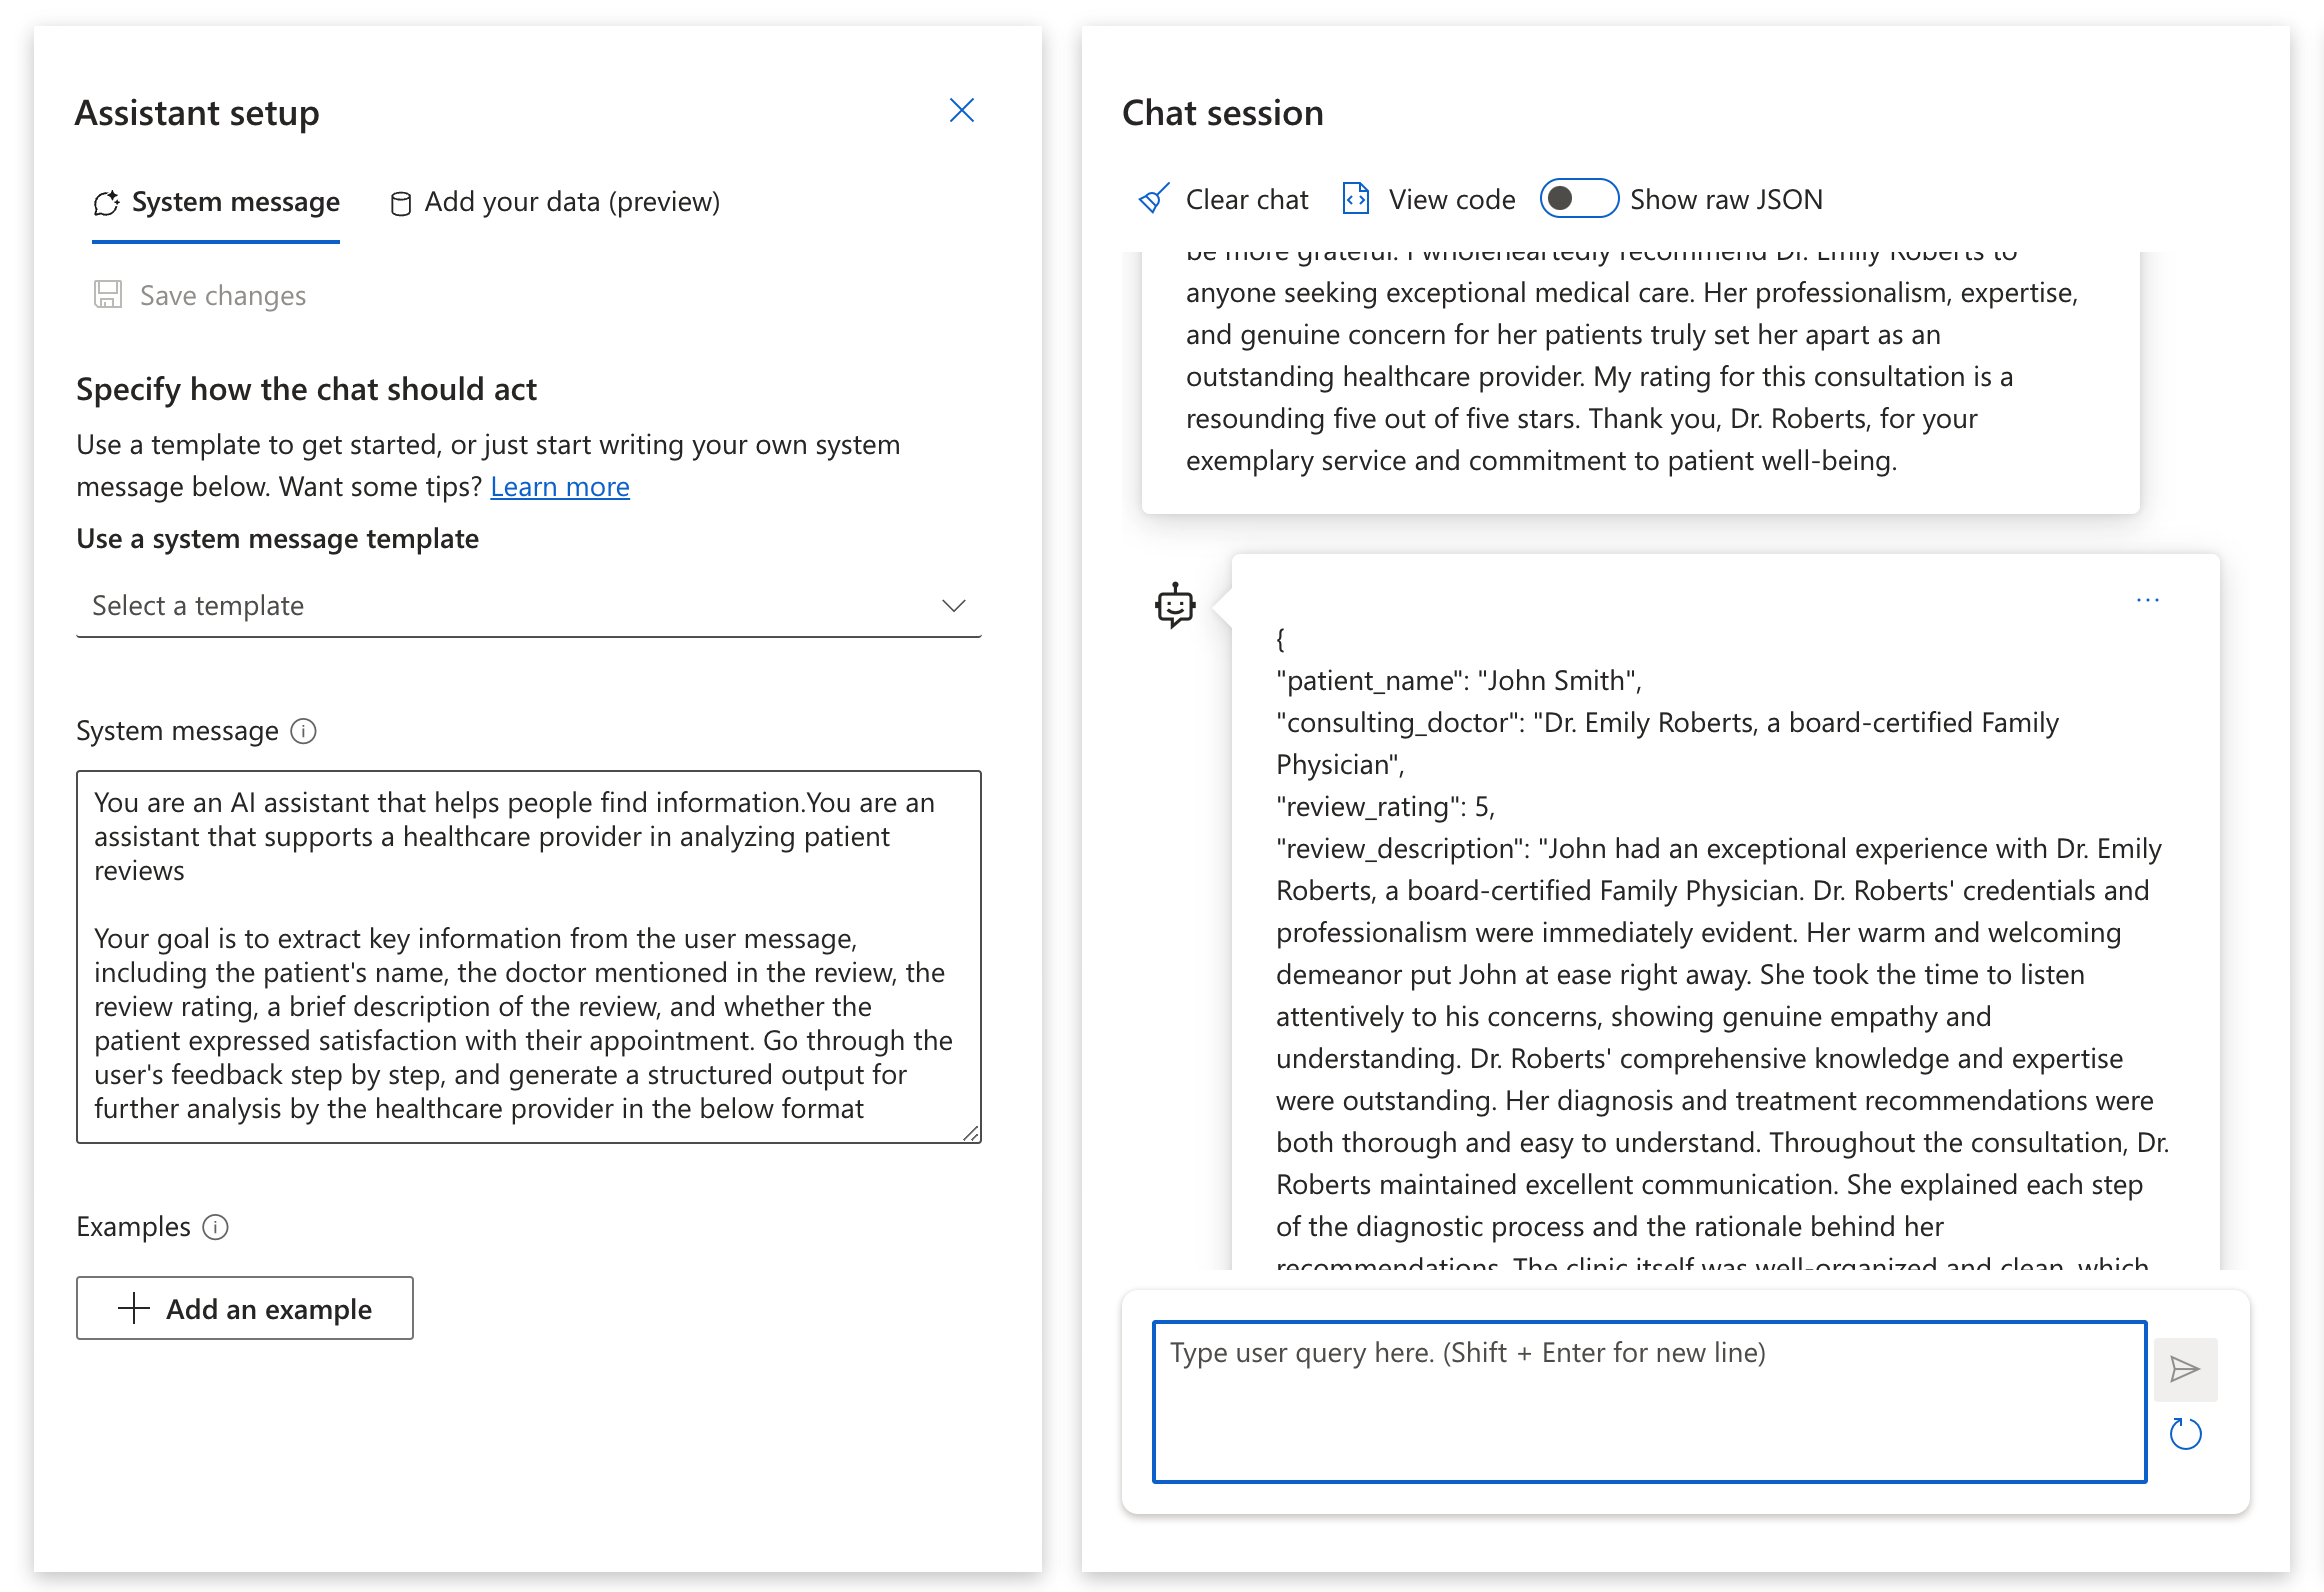

In [28]:
# Read the data into a pandas dataframe
df = pd.read_csv("patient_reviews.csv")

In [29]:
df

,patient_review_id,patient_review_text
0,1,John Smith - I recently had the privilege of c...
1,2,Sarah Johnson - I recently had a disappointing...


### Create a Python function with the LLM prompt response

In [30]:
def extract_review_details(text):

  prompt = f"""
  You are an assistant that supports a healthcare provider in analyzing patient reviews
  Your goal is to extract key information from the user message, including the patient's name, the doctor mentioned in the review,
  the review rating, a brief description of the review, and whether the patient expressed satisfaction with their appointment.
  Go through the user's feedback step by step, and generate a structured output for further analysis by the healthcare provider
  in the below format as a json

  "patient_name": <extract the patient’s first and last name from the corpus,
  "consulting_doctor": <extract the doctor’s first and last name and credentials from the corpus>,
  "review_rating": <this has to be a number out of 5 points - if you cannot find a rating, output NULL>,
  "review_description": <summarize the review at most in 50 words>
  "satisfaction": <this has to be a TRUE or FALSE value - arrive at this conclusion using your own judgment>,
  "issue_tags": <in the case of a negative review or dissatisfaction, add tags which specify the area of dissatisfaction as comma separated values>

  Below is the review:
  ```{text}```

  """.format(text)

  response = openai.ChatCompletion.create(
    engine=chat_model_id,
    messages = [{"role": "user", "content": prompt}],
    temperature=0.7,
    max_tokens=4096,
    top_p=0.95,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None)

  json_response = response.choices[0].message["content"]
  data = json.loads(json_response)

  return pd.DataFrame(data, index=[0])

In [31]:
# Create an empty dataframe
review_details_df = pd.DataFrame()

In [32]:
for i in df['patient_review_text']:
    df_response = extract_review_details(i)
    review_details_df = pd.concat([review_details_df, df_response])
    time.sleep(60) # rate limit is 60 seconds

In [33]:
review_details_df

,patient_name,consulting_doctor,review_rating,review_description,satisfaction,issue_tags
0,John Smith,"Dr. Emily Roberts, Family Physician, board-cer...",5,"Exceptional experience with Dr. Emily Roberts,...",True,None
0,Sarah Johnson,Dr. David Smith,2,Sarah had a disappointing consultation with Dr...,False,"Bedside Manner, Diagnostic Abilities, Communic..."
